In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download("omw-1.4")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
from collections import Counter
import pandas as pd
from itertools import islice

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Helvetica']})

from lyricsgenius import Genius
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ** [ DO NOT RUN THIS - DATA ALREADY PROVIDED ] **
# Data scraping

In [2]:
# Authenticate with Genius API
genius = Genius('FeuRaslWUfDgOWiEO3QS6l2vmWY5i0oHH4fiMtz7-LLuYy8NR5JFkTc92ZwQgmR-', verbose=False, timeout=20)

# fetch the top 50 song names and artists from billboard.com
def get_top50_from_url(year):
    #example = url_start + '2018' + url_end
    url_start = 'https://www.billboard.com/charts/year-end/'
    url_end = '/hot-rap-songs/'

    url = url_start + str(year) + url_end
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')
    results = soup.find_all('div', {'class': 'o-chart-results-list-row-container'})

    data = []

    for i in range(len(results)):
        result = results[i]
        title = result.find('h3').text.strip()
        spans = result.find_all('span')
        artist = spans[1].text.strip()
        data.append({'position': i+1, 'title': title, 'artist': artist, 'year': year})

    df = pd.DataFrame(data)
    return df


# gets the lyrics and primary artists given a artist name and song title (using the Genius API)
def get_lyrics_and_primary_artist(df):
    lyrics = []
    primary_artists = []
    for i, row in tqdm(df.iterrows(), desc="songs", position=0, leave=True):
        artist = row["artist"]
        title = row["title"]

        genius_fetch = genius.search_song(title, artist)
        # check whether its the translated version....
        if genius_fetch is not None and "Genius" in genius_fetch.primary_artist.name:
            # try alternative
            artist = artist.lower()
            if "featuring" in artist:
                a = artist.split("featuring")[0]
                genius_fetch = genius.search_song(title, a)
            elif "ft." in artist:
                a = artist.split("ft.")[0]
                genius_fetch = genius.search_song(title, a)

        if genius_fetch is None:
            lyrics.append(None)
            primary_artists.append(None)
        else:
            lyrics.append(genius_fetch.lyrics)
            primary_artists.append(genius_fetch.primary_artist.name)

    return lyrics, primary_artists


# cleans lyrics
def clean_lyrics(lyrics):
    # remove everything until the first occurence of Lyrics (including this word)
    lyrics = re.sub(r'^.*?Lyrics', '', lyrics)
    #
    lyrics = lyrics.replace("\u2005"," ")
    # remove all tags ( tag: [ XX ]
    lyrics = re.sub(r'\[.+?\]','',lyrics)
    # the last word contains 000Embeded, where 000 is any number. remove this
    lyrics = re.sub(r"\d*Embed$",'', lyrics)
    # no need for \n
    lyrics = lyrics.replace("\n"," ")
    # remove multiple spaces
    lyrics = re.sub('\s+',' ', lyrics).strip()
    return lyrics

# ALREADY EXECUTED! Data already provided (takes a few minutes)

#dfs = []
#for y in tqdm(range(2018,2023), desc="Year"):
#    # get top 50 rap songs for given year
#    df = get_top50_from_url(y)
#    # get the primary artists and cleaned lyrics for each song
#    lyrics, primary_artists = get_lyrics_and_primary_artist(df)
#    # clean the lyrics
#    cleaned_lyrics = []
#    for l in lyrics:
#        if l is None:
#            cleaned_lyrics.append(None)
#        else:
#            cleaned_lyrics.append(clean_lyrics(l))
#    # add them to df
#    df["Lyrics"] = cleaned_lyrics
#    df["Primary Artists"] = primary_artists

#    dfs.append(df)

#df_all = pd.concat(dfs)
#df_all.to_csv('data/top50.csv', index=False)

# RUN FROM HERE AGAIN :)
# Preprocessing

In [3]:
def create_rap_df(remove_stopwords=False, lemmatize=False, trim_swearwords=False):
    # load in top50_2018_2022.csv
    df = pd.read_csv("data/top50_2018_2022.csv", encoding = 'unicode_escape')
    # this csv has a column with the lyrics in one string

    # we should split the primary artists for explode to work
    df["Primary Artists"] = df["Primary Artists"].str.replace(" & ", ",")
    df["Primary Artists"] = df["Primary Artists"].str.replace(", ", ",")
    df["Primary Artists"] = df["Primary Artists"].str.split(",")

    # apply preprocess function to each list in the lyrics column
    df["Lyrics"] = df["Lyrics"].apply(lambda x: preprocess(x, remove_stopwords=remove_stopwords, lemmatize=lemmatize, trim_swearwords=trim_swearwords))

    return df


# trims chosen swear words to their core
def preprocess_swear_word(word):
    if "motherfuck" in word or word.startswith("mothaf"):
        return "motherfuck"
    if word.startswith("fuck"):
        return "fuck"
    return word


# preprocess the lyrics
def preprocess(lyrics, remove_stopwords=False, lemmatize=False, trim_swearwords=False):
    # Remove punctuation
    lyrics = re.sub("[^a-zA-Z0-9\s]", "", lyrics)
    # Convert to lowercase
    lyrics = lyrics.lower()
    # Tokenize into individual words
    stop_words = []
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
    if lemmatize:
        # lemmatize words (and check whether they are noun, verb, or lemmatize them accordingly
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ["a","n","v"] else lemmatizer.lemmatize(i) for i,j in nltk.pos_tag(nltk.word_tokenize(lyrics))]
    else:
        tokens = lyrics.split()
    if trim_swearwords:
        # remove stop words
        words = [preprocess_swear_word(w) for w in tokens if w not in stop_words]
    else:
        words = [w for w in tokens if w not in stop_words]
    return words


# a dictionary containing the word count of lyrics in a df
def create_word_count_dict(df):
    # create a dictionary of words and their counts and their relative frequencies
    # without grouping, just combine all lists into one list and count
    words = df["Lyrics"].sum()
    return dict(Counter(words))


def create_word_count_dict_grouped(df, artists=False, year=False):
    # the dict. must contain at least one of the two columns
    assert artists or year

    songs = df.copy()
    groupby = []

    # what columns to group
    if artists:
        songs = songs.explode('Primary Artists')
        groupby.append("Primary Artists")
    if year:
        groupby.append("year")

    grouped_lyrics = songs.groupby(groupby)['Lyrics'].sum().reset_index()

    # key by the column values (artists / year)
    word_counts = {}
    for i, row in grouped_lyrics.iterrows():
        key = tuple(row[gb] for gb in groupby)
        counts = dict(Counter(row['Lyrics']))
        if key in word_counts:
            word_counts[key].update(counts)
        else:
            word_counts[key] = counts

    return word_counts

# Vocabulary analysis

In [4]:
def take(n, iterable, dirc="first"):
    """Return the first or last n items of the dictionary as a list."""
    assert dirc == "first" or dirc == "last"
    if dirc == "first":
        return list(islice(iterable, n))
    elif dirc == "last":
        return list(iterable.items())[-n:]

In [5]:
songs_data = create_rap_df()

In [6]:
unfix_word_counts_by_artist = create_word_count_dict_grouped(songs_data, artists=True)
# Fix key of dictionary
word_counts_by_artist = {}
for (artist,), word_dict in unfix_word_counts_by_artist.items():
    word_counts_by_artist[artist] = word_dict

total_words_by_artist = {}
unique_words_by_artist = {}
total_word_length_by_artist = {}

for artist, word_dict in word_counts_by_artist.items():
    total_words_by_artist[artist] = sum(word_dict.values())
    unique_words_by_artist[artist] = len(word_dict)

    for word, freq in word_dict.items():
        if artist in total_word_length_by_artist.keys():
            total_word_length_by_artist[artist] += len(word) * freq
        else:
            total_word_length_by_artist[artist] = len(word) * freq

average_word_length_by_artist = {}
for artist, tot_len in total_word_length_by_artist.items():
    average_word_length_by_artist[artist] = tot_len / total_words_by_artist[artist]

unique_ratio_by_artist = {}
for artist, tot_num in total_words_by_artist.items():
    unique_ratio_by_artist[artist] = unique_words_by_artist[artist] / tot_num

In [7]:
# Sort them all:
total_words_by_artist = dict(sorted(total_words_by_artist.items(), reverse=True, key=lambda item: item[1]))
unique_words_by_artist = dict(sorted(unique_words_by_artist.items(), reverse=True, key=lambda item: item[1]))
average_word_length_by_artist = dict(sorted(average_word_length_by_artist.items(), reverse=True, key=lambda item: item[1]))
unique_ratio_by_artist = dict(sorted(unique_ratio_by_artist.items(), reverse=True, key=lambda item: item[1]))

C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\79946411.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=[i[0] for i in first_n_avg_length], rotation=55, ha="right") # rotate labels 45 degrees and align to the right
C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\79946411.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=[i[0] for i in last_n_avg_length],rotation=55, ha="right") # rotate labels 45 degrees and align to the right


Text(0.5, 0.98, 'Average Word Length Of Top 5 And Lowest 5 Artists')

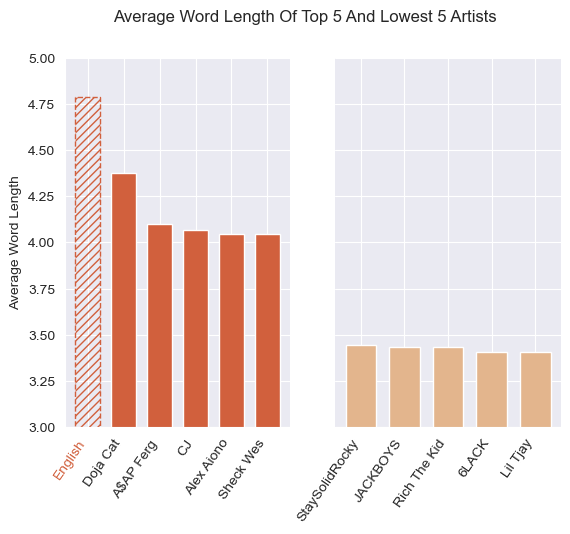

In [8]:
n = 5
AVG_LEN_EN = 4.79 # See: http://norvig.com/mayzner.html

first_n_avg_length = take(n, average_word_length_by_artist.items())
first_n_avg_length.append(("English", AVG_LEN_EN))
first_n_avg_length = sorted(first_n_avg_length, key=(lambda x: x[1]), reverse=True)
last_n_avg_length = take(n, average_word_length_by_artist, dirc="last")

bar_colors = ['#D1603D', '#E3B58D'] # orange-brown colors
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

bars1 = ax1.bar([i[0] for i in first_n_avg_length], [i[1] for i in first_n_avg_length], color=bar_colors[0], width=0.7)
english_bar = bars1[[i[0] for i in first_n_avg_length].index('English')]
english_bar.set_fill(False)
english_bar.set_color('#D1603D')
english_bar.set_linestyle('dashed')
english_bar.set_hatch('////')
english_label = ax1.get_xticklabels()[[i[0] for i in first_n_avg_length].index('English')]
english_label.set_color('#D1603D')

ax2.bar([i[0] for i in last_n_avg_length], [i[1] for i in last_n_avg_length], color=bar_colors[1], width=0.7)
ax1.set_xticklabels(labels=[i[0] for i in first_n_avg_length], rotation=55, ha="right") # rotate labels 45 degrees and align to the right
ax2.set_xticklabels(labels=[i[0] for i in last_n_avg_length],rotation=55, ha="right") # rotate labels 45 degrees and align to the right

plt.ylim([3, 5]) # set the upper y-limit slightly above the highest value

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.tick_params(axis='y', which='both', length=0)

ax1.set_ylabel("Average Word Length")
plt.suptitle("Average Word Length Of Top 5 And Lowest 5 Artists")


It seems that rappers have a smaller average word length than in the English language. This is likely because of the fact that rappers tend to shorten words in their songs.
Overall, Doja Cat seems to have the highest average word length by a large margin.

C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\3814997067.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=[i[0] for i in first_n_unique], rotation=45, ha="right") # rotate labels 45 degrees and align to the right
C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\3814997067.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=[i[0] for i in last_n_unique],rotation=45, ha="right") # rotate labels 45 degrees and align to the right


Text(0.5, 0.98, 'Unique Word Ratio Of Top 7 And Lowest 7 Artists')

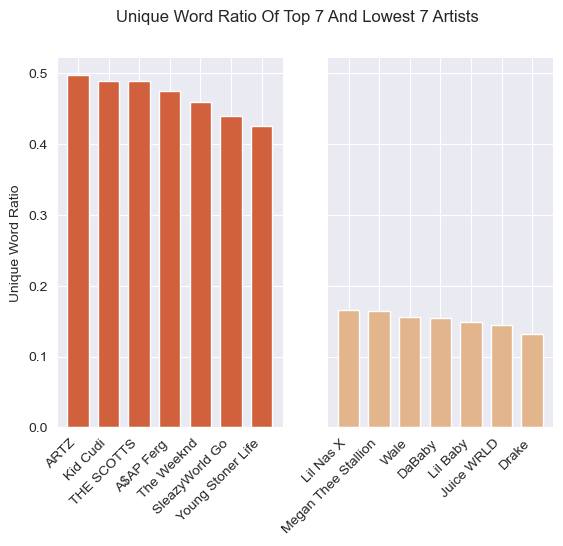

In [9]:
n = 7
first_n_unique = take(n, unique_ratio_by_artist.items())
last_n_unique = take(n, unique_ratio_by_artist, dirc="last")

bar_colors = ['#D1603D','#E3B58D'] # orange-brown colors
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.bar([i[0] for i in first_n_unique], [i[1] for i in first_n_unique], color=bar_colors[0], width=0.7)
ax2.bar([i[0] for i in last_n_unique], [i[1] for i in last_n_unique], color=bar_colors[1], width=0.7)
ax1.set_xticklabels(labels=[i[0] for i in first_n_unique], rotation=45, ha="right") # rotate labels 45 degrees and align to the right
ax2.set_xticklabels(labels=[i[0] for i in last_n_unique],rotation=45, ha="right") # rotate labels 45 degrees and align to the right

# plt.ylim([0,0.7]) # set the upper y-limit slightly above the highest value

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.tick_params(axis='y', which='both', length=0)

ax1.set_ylabel("Unique Word Ratio")
plt.suptitle("Unique Word Ratio Of Top 7 And Lowest 7 Artists")

It seems like there is a very large difference in the unique word ratio between the top and bottom artists. The bottom artists tend to make songs with a lot of repetition and focus on melody rather than lyrics.

# English & Rap Comparison

In [10]:
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import words, stopwords
import matplotlib.pyplot as plt

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# load in rap data
rap_data = create_rap_df(remove_stopwords=True,lemmatize=True)
word_count_dict = create_word_count_dict(rap_data)
# please create a new dataframe where the key in word_count_dict is one column called 'word' and the value is the other column called 'count'
rap_words = pd.DataFrame({'word': list(word_count_dict.keys()), 'count': list(word_count_dict.values())})

# load in swearwords
swearwords_data = pd.read_csv("data/bad-words.csv")
# rename jigaboo column into 'swearword'
swearwords_data.rename(columns={'jigaboo': 'swearword'}, inplace=True)

# load in english data
english_words = pd.read_csv('data/english-words-freq.csv')
# legal english words
word_list = set(words.words())
# create a set of stopwords
stop_words = set(stopwords.words('english'))

In [12]:
def add_frequency(df):
    # calculate relative frequency: important first calculate frequency, then remove stopwords, otherwise alter distribution
    N = df['count'].sum()
    df['freq'] = df['count'] / N

    return df

def censor_swear_words(df):
    # classify as swearword or not
    df['is_swearword'] = df['word'].isin(swearwords_data['swearword'])

    # censor swearwords:
    df.loc[df['is_swearword'], 'word'] = df.loc[df['is_swearword'], 'word'].apply(lambda x: re.sub('[aeiouAEIOU]', '*', x))

    return df

def remove_non_words(df):
    # remove all words that are not in the english word list from the english words df
    df = df[df['word'].isin(word_list)]
    # remove stopwords from the 'words' column
    df = df[~df['word'].isin(stop_words)]
    return df

In [13]:
# prep english words
english_words = remove_non_words(english_words)
english_words = add_frequency(english_words)
english_words = censor_swear_words(english_words)
# prep rap words
rap_words = add_frequency(rap_words)
rap_words = censor_swear_words(rap_words)

In [14]:
english_words.sort_values(by='freq', ascending=False).head(n)

,word,count,freq,is_swearword
26,new,1551258643,0.005814,False
32,home,1276852170,0.004786,False
34,us,1229112622,0.004607,False
37,page,1082121730,0.004056,False
40,search,1024093118,0.003838,False
41,free,1014107316,0.003801,False
44,one,993536631,0.003724,False


In [15]:
rap_words.sort_values(by='freq', ascending=False).head(n)

,word,count,freq,is_swearword
25,get,2463,0.028226,False
1,yeah,2188,0.025074,False
64,im,2052,0.023516,False
15,like,1805,0.020685,False
124,n*gg*,1087,0.012457,True
107,b*tch,1084,0.012423,True
4,dont,1036,0.011872,False


In [16]:
def format_label(label):
    if label > 0.0001:
        return str('{:.2%}'.format(label))
    else:
        return '0%'

def plot_top_n(n, focus_swearwords=False):
    bar_colors = ['#E3B58D','#D1603D'] # orange-brown colors
    if not focus_swearwords:
        english_top_n = english_words.sort_values(by='freq', ascending=False).head(n)
        rap_top_n = rap_words.sort_values(by='freq', ascending=False).head(n)
        focus = "Words"
    else:
        english_top_n = english_words.sort_values(by=['is_swearword','freq'], ascending=[False,False]).head(n)
        rap_top_n = rap_words.sort_values(by=['is_swearword','freq'], ascending=[False,False]).head(n)
        focus = "Swearwords"

    ymax = max(english_top_n['freq'].max(), rap_top_n['freq'].max()) + 0.01

    english_top_n = english_top_n.merge(rap_words[['word', 'count','freq']], on='word', suffixes=('', '_rap'), how='left')
    # --- RAP
    rap_top_n = rap_top_n.merge(english_words[['word', 'count', 'freq']], on='word', suffixes=('', '_english'), how='left')

    # Filter rows where 'count_english' is null (i.e., words not in english_words)
    rap_top_n[rap_top_n['count_english'].isnull()]['count_english'] = 0
    rap_top_n[rap_top_n['count_english'].isnull()]['freq_english'] = 0
    rap_top_n = rap_top_n.drop(['count_english'], axis=1)
    # --- RAP END --

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    english_top_n.plot.bar(x='word', y=['freq', 'freq_rap'], ax=ax1, stacked=False, color=bar_colors)
    for p in ax1.patches:
        ax1.annotate(format_label(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax1.set_xlabel(focus)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.legend(['Frequency', 'Frequency Rap'])
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1%}".format(x)))
    ax1.set_title(f'English Top {n} Most Common {focus}, compared to Rap')
    ax1.set_ylim(0, ymax)
    rap_top_n.plot.bar(x='word', y=['freq_english', 'freq'], ax=ax2, stacked=False, color=bar_colors)
    for p in ax2.patches:
        ax2.annotate(format_label(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax2.set_xlabel(focus)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.legend(['Frequency English','Frequency'])
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.1%}".format(x)))
    ax2.set_title(f'Rap Top {n} Most Common {focus}, compared to English')
    ax2.set_ylim(0, ymax)
    fig.suptitle(f'Comparison of Top {n} Most Common {focus}')
    plt.show()


C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\922163060.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rap_top_n[rap_top_n['count_english'].isnull()]['count_english'] = 0
C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\922163060.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rap_top_n[rap_top_n['count_english'].isnull()]['freq_english'] = 0


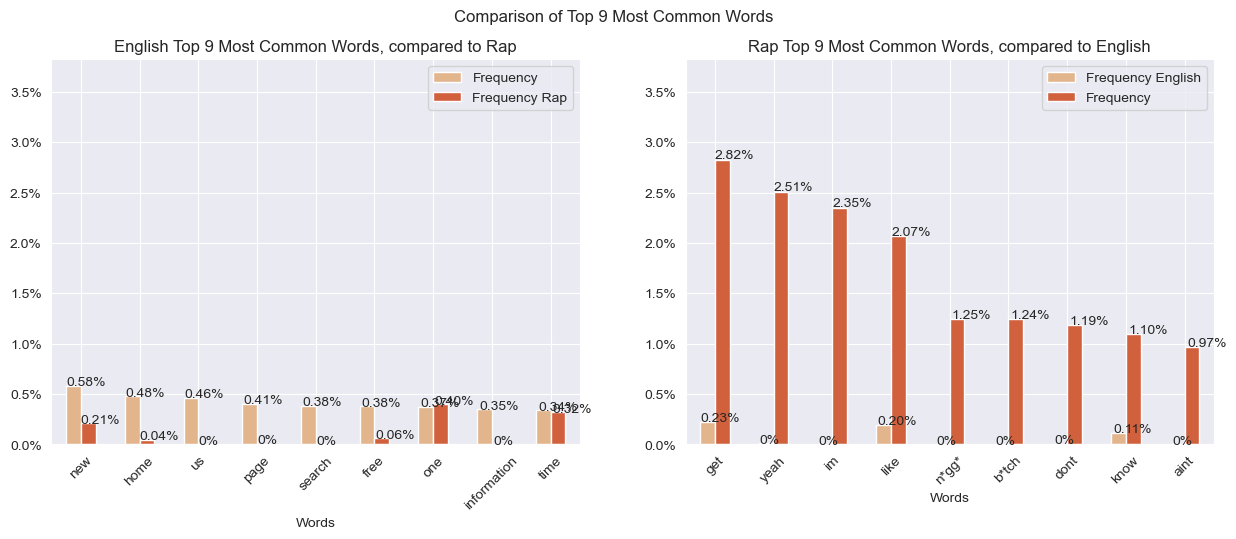

In [17]:
plot_top_n(9)

C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\922163060.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rap_top_n[rap_top_n['count_english'].isnull()]['count_english'] = 0
C:\Users\Surface\AppData\Local\Temp\ipykernel_18392\922163060.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rap_top_n[rap_top_n['count_english'].isnull()]['freq_english'] = 0


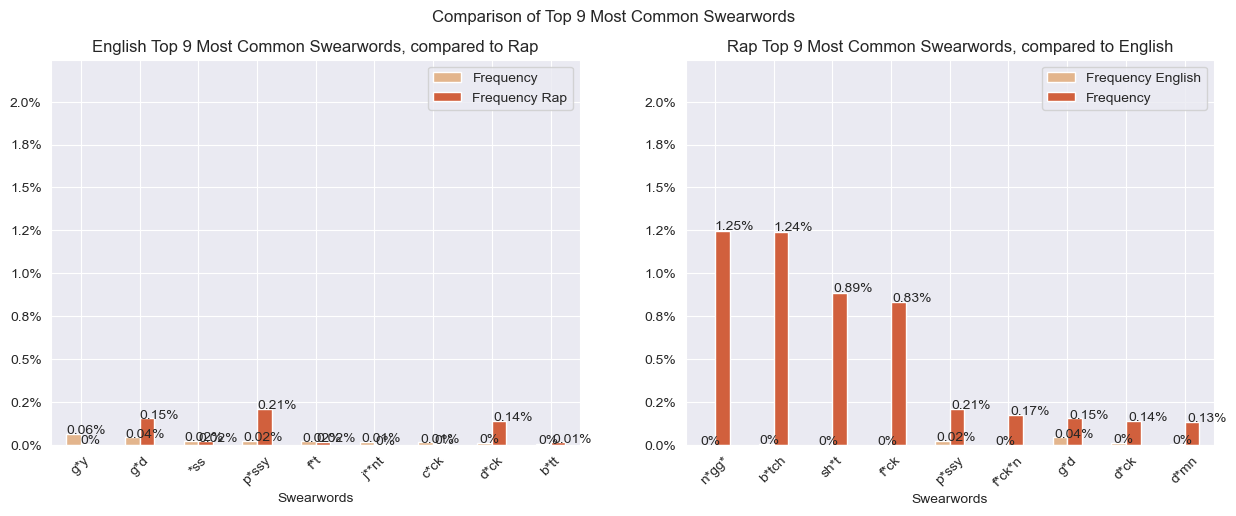

In [18]:
plot_top_n(9, focus_swearwords=True)

In [19]:
def plot_swearword_pie():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    rap_swearwords_ratio = rap_words[rap_words['is_swearword'] == True]['freq'].sum()
    english_swearwords_ratio = english_words[english_words['is_swearword'] == True]['freq'].sum()
    # plot pie chart
    ax2.pie([rap_swearwords_ratio, 1 - rap_swearwords_ratio], labels=['Vulgar', 'Non-Vulgar'], autopct='%1.2f%%', colors=bar_colors[::-1])
    ax2.set_title('Rap')
    ax1.pie([english_swearwords_ratio, 1 - english_swearwords_ratio], labels=['Vulgar', 'Non-Vulgar'], autopct='%1.2f%%', colors=bar_colors[::-1])
    ax1.set_title('English')
    fig.suptitle('Ratio of Vulgar Words in Rap vs. English')
    plt.show()

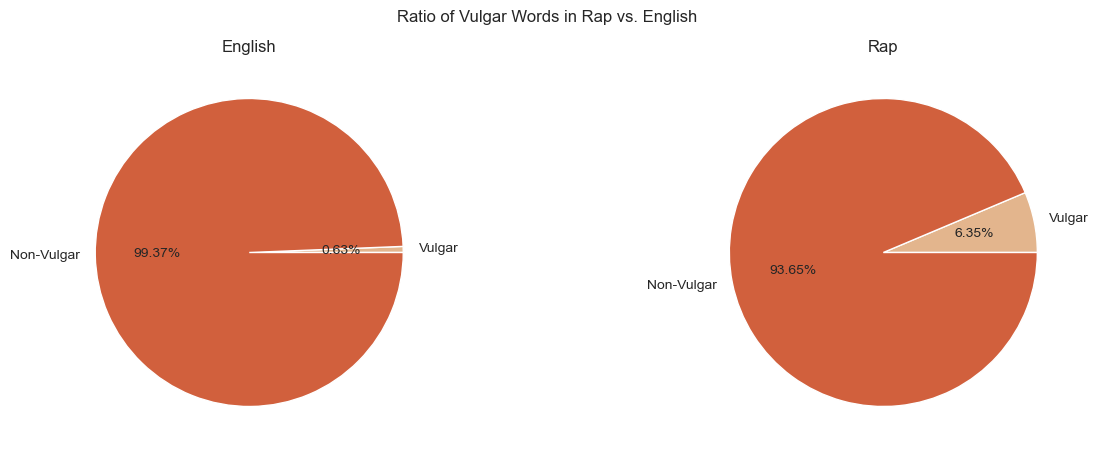

In [20]:
plot_swearword_pie()

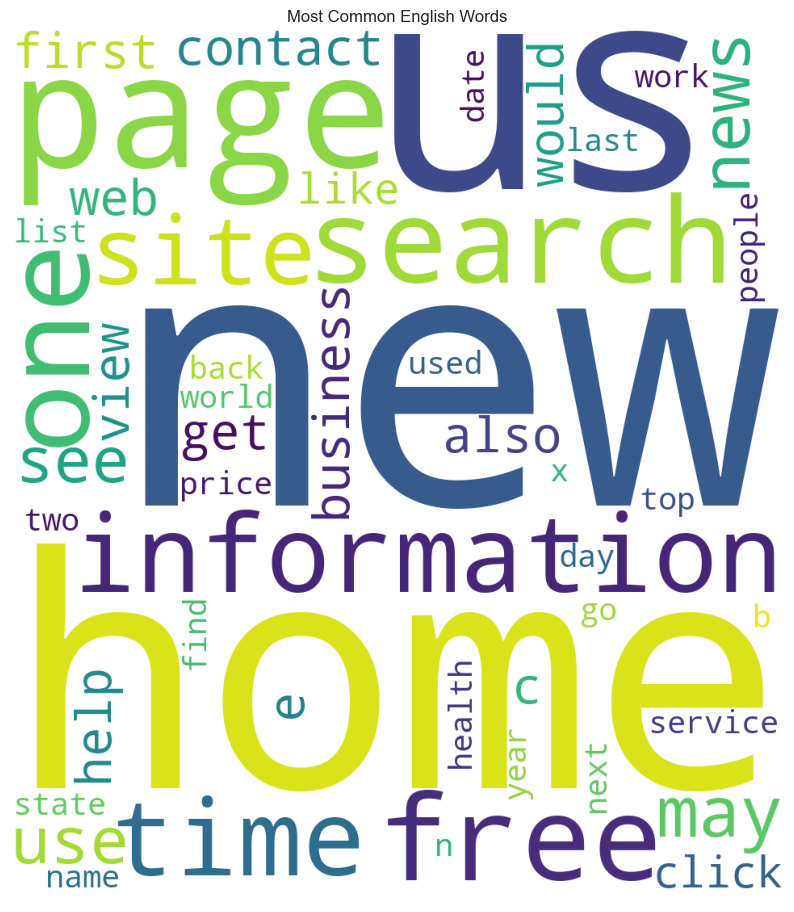

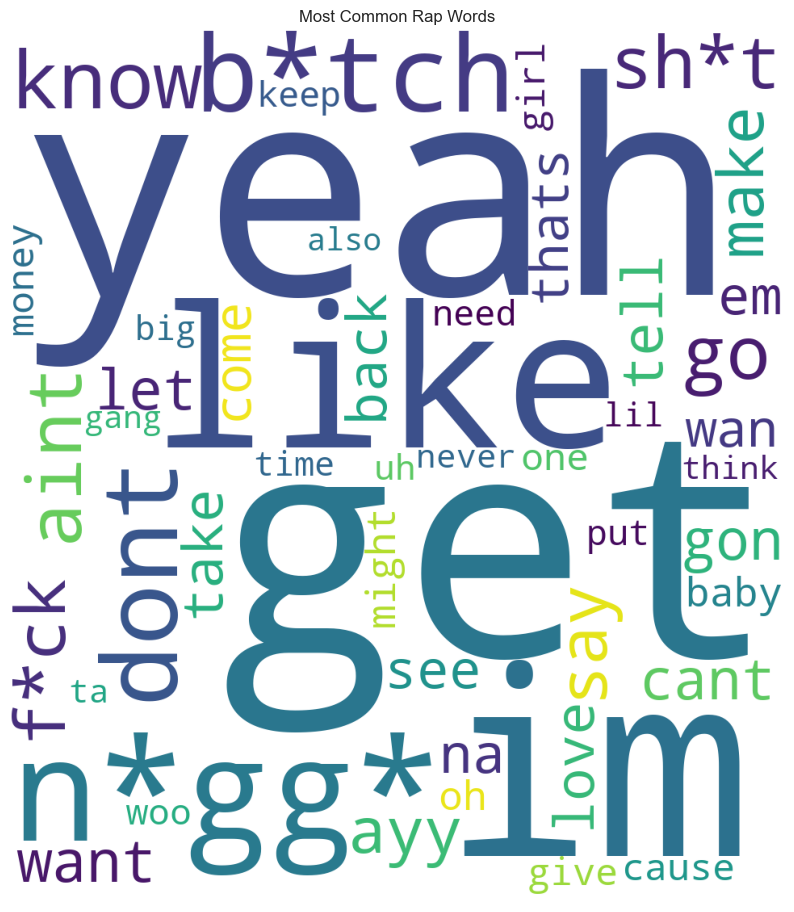

In [21]:
wordcloud = WordCloud(width=960, height=1080, background_color="white", contour_color=bar_colors[0])
english_top_n = english_words.sort_values(by=['freq'], ascending=[False]).head(50)
english_swear_word_freq = dict(zip(english_top_n['word'], english_top_n['freq']))
wordcloud.generate_from_frequencies(english_swear_word_freq)

plt.figure(figsize=(10, 19))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most Common English Words")
plt.show()

wordcloud = WordCloud(width=960, height=1080, background_color="white", contour_color=bar_colors[0])
rap_top_n = rap_words.sort_values(by=['freq'], ascending=[False]).head(50)
rap_swear_word_freq = dict(zip(rap_top_n['word'], rap_top_n['freq']))
wordcloud.generate_from_frequencies(rap_swear_word_freq)

plt.figure(figsize=(10, 19))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most Common Rap Words")
plt.show()

# Swear word analysis
Analysis of vulgarity in rap. We will look at the most common vulgar words, who uses them and which songs contain most of them.


To identify swear words, we use the following data set: https://www.kaggle.com/datasets/nicapotato/bad-bad-words

In [22]:
# load data
songs_data = create_rap_df(remove_stopwords=True, lemmatize=True, trim_swearwords=True)

bad_words_data = pd.read_csv("data/bad-words.csv")
# remove some words from the bad_words_data
not_bad_words = ["gun","blow","black","chinese","bigger"]
bad_words_data = bad_words_data.drop(index=bad_words_data[bad_words_data["jigaboo"].isin(not_bad_words)].index)

In [23]:
# converts a dict to a df
def word_count_dict_to_df(word_dict):
    df = pd.DataFrame.from_dict(word_dict, orient="index", columns=["count"])#.reset_index()
    df.index.name = "word"
    return df

In [24]:
def censor_vulgarity(df_original):
    word_mapping = {}

    for index, row in df_original.iterrows():
        if row['swear word']:
            censored_word = re.sub('[aeiouAEIOU]', '*', index)
            word_mapping[index] = censored_word

    return df_original.rename(index=word_mapping)

In [25]:
# I want a df with all the word counts and whether they are swear words
all_words_swear = word_count_dict_to_df(create_word_count_dict(songs_data))
all_words_swear["swear word"] = all_words_swear.index.isin(bad_words_data["jigaboo"])
# sort
all_words_swear = all_words_swear.sort_values(["swear word", "count"], ascending=[False, False])
all_words_swear = censor_vulgarity(all_words_swear)
all_words_swear

,count,swear word
word,,
n*gg*,1087,True
b*tch,1084,True
f*ck,886,True
sh*t,773,True
p*ssy,183,True
...,...,...
akimbos,1,False
mitt,1,False
kimbo,1,False


In [26]:
# a dictionary of word use per year and artist
words_dict = create_word_count_dict_grouped(songs_data, True, True)
# create df
words_df_dict = {}
for key in words_dict.keys():
    words_df_dict[key] = word_count_dict_to_df(words_dict[key])
    words_df_dict[key]["swear word"] = words_df_dict[key].index.isin(bad_words_data["jigaboo"])
    # sort
    words_df_dict[key] = words_df_dict[key].sort_values(["swear word", "count"], ascending=[False, False])
    words_df_dict[key] = censor_vulgarity(words_df_dict[key])

# also a df just for the year
words_year_dict = create_word_count_dict_grouped(songs_data, False, True)
words_df_year_dict = {}
for key in words_year_dict.keys():
    words_df_year_dict[key] = word_count_dict_to_df(words_year_dict[key])
    words_df_year_dict[key]["swear word"] = words_df_year_dict[key].index.isin(bad_words_data["jigaboo"])
    # sort
    words_df_year_dict[key] = words_df_year_dict[key].sort_values(["swear word", "count"], ascending=[False, False])

# also a df just for the year but censored
words_df_year_dict_censor = {}
for key in words_year_dict.keys():
    words_df_year_dict_censor[key] = word_count_dict_to_df(words_year_dict[key])
    words_df_year_dict_censor[key]["swear word"] = words_df_year_dict_censor[key].index.isin(bad_words_data["jigaboo"])
    # sort
    words_df_year_dict_censor[key] = words_df_year_dict_censor[key].sort_values(["swear word", "count"], ascending=[False, False])
    words_df_year_dict_censor[key] = censor_vulgarity(words_df_year_dict_censor[key])

In [27]:
# Count total swear word count per year per artist
swear_by_year_artist = pd.DataFrame()

for (artist, year), df in words_df_dict.items():
    total_word_count = df["count"].sum()
    swear_count = df[df["swear word"]]["count"].sum()
    swear_proportion = swear_count / total_word_count

    temp_df = pd.DataFrame({"year": year, "artist": artist, "swear_count": swear_count, "total_word_count": total_word_count, "swear_proportion": swear_proportion}, index=[0])
    swear_by_year_artist = pd.concat([swear_by_year_artist, temp_df], ignore_index=True)

top_artists = swear_by_year_artist.groupby("artist")["swear_proportion"].sum().sort_values(ascending=False).head(10).index.tolist()

swear_by_year_artist

,year,artist,swear_count,total_word_count,swear_proportion
0,2018,21 Savage,68,442,0.153846
1,2019,21 Savage,30,518,0.057915
2,2021,21 Savage,60,727,0.082531
3,2020,24kGoldn,1,239,0.004184
4,2020,42 Dugg,34,493,0.068966
...,...,...,...,...,...
201,2021,Young Thug,13,290,0.044828
202,2018,YoungBoy Never Broke Again,8,242,0.033058
203,2020,YoungBoy Never Broke Again,25,330,0.075758
204,2022,Yung Gravy,7,280,0.025000


## Popular Vulgar Words
### Word Cloud of most frequent vulgar words
The word cloud displays the most prominent vulgar words in rap songs which a bigger font size.

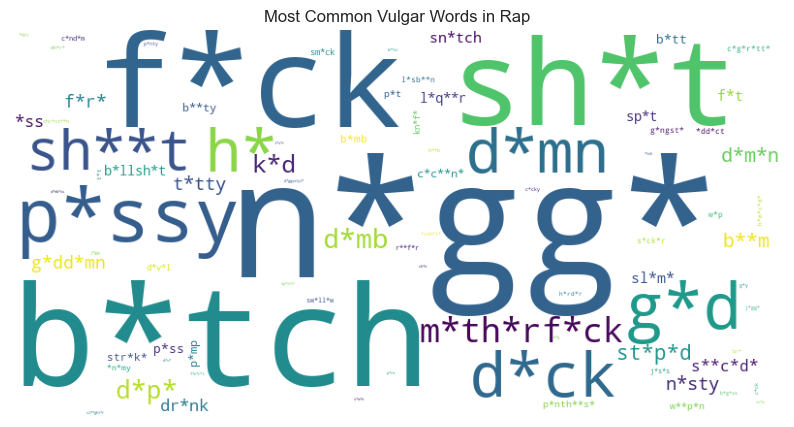

In [28]:
swear_word_freq = all_words_swear[all_words_swear["swear word"]]["count"].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(swear_word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most Common Vulgar Words in Rap")
plt.show()

### Which year saw the highest usage of vulgar words (proportional to the total number of words)?
As can be seen on the bar plot, the trend of using vulgar words barely changes over the years 2018 to 2022. In this range, 2019 saw the highest proportion of swear words (8.4%).

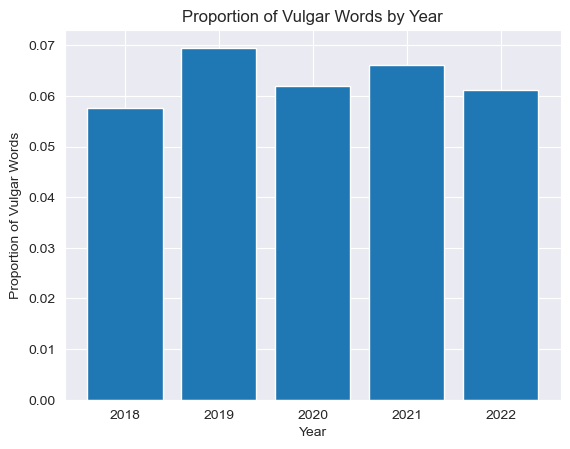

In [29]:
swear_proportions_by_year = {}

for year, df in words_df_year_dict.items():
    total_word_count = df["count"].sum()
    swear_count = df[df["swear word"]]["count"].sum()
    swear_proportion = swear_count / total_word_count
    swear_proportions_by_year[year] = swear_proportion

years = [year[0] for year in words_df_year_dict.keys()]
proportions = list(swear_proportions_by_year.values())

plt.bar(years, proportions)
plt.xlabel("Year")
plt.ylabel("Proportion of Vulgar Words")
plt.title("Proportion of Vulgar Words by Year")
plt.show()

### Development of popularity of vulgar words over years
Generally, the popularity of each of the most common vulgar words does not change over the years. A notable change can be seen in the word "shit" though. After 2020, transitioning to 2021, it experienced a sharp increase in usage.

A word that appears to have an upward trend in popularity is "Pussy" - the 5th most popular word in years 2019 to 2022.

In [30]:
words_df_year_dict[2021,]

,count,swear word
word,,
nigga,238,True
shit,231,True
bitch,220,True
fuck,190,True
shoot,38,True
...,...,...
brown,1,False
gut,1,False
tinder,1,False


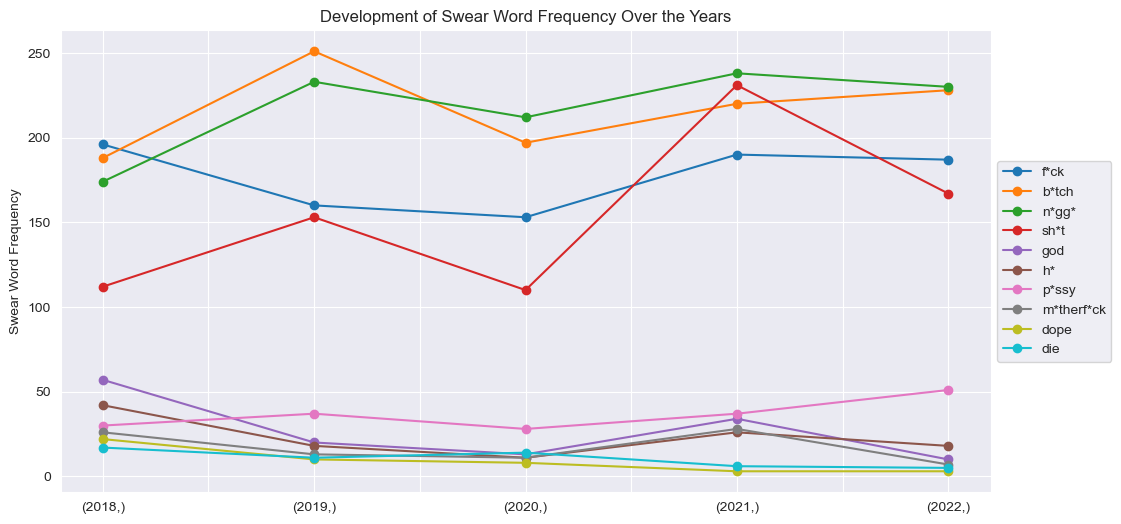

In [31]:
swear_freq_by_year = pd.DataFrame()

for year, df in words_df_year_dict.items():
    swear_words = df[df["swear word"]]
    swear_freq = swear_words["count"]
    swear_freq.index = swear_words.index
    temp_df = pd.DataFrame(swear_freq).T
    temp_df.index = [year]
    swear_freq_by_year = pd.concat([swear_freq_by_year, temp_df], ignore_index=False)

# Select the first 10 columns
swear_freq_by_year = swear_freq_by_year.iloc[:, :10]

swear_freq_by_year.plot(marker="o", linestyle="-", figsize=(12, 6))
plt.ylabel("Swear Word Frequency")
plt.title("Development of Swear Word Frequency Over the Years")
# to censor
# Move the legend outside of the plot area to the right
plt.legend(["f*ck","b*tch","n*gg*","sh*t", "god", "h*", "p*ssy", "m*therf*ck", "dope", "die"], loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## Which artist is the most toxic one?
To answer that question, we look at the artists with the highest proportion of vulgar words in their song lyrics.


"Sheck Wes" had the highest proportion of vulgar words across his songs, almost 30 per cent!
However, multiple artists exist that barely use any swear words - as the bar plot illustrates.

A heatmap intends to display the development of the vulgar word usage among the artists in each year. Overall it is safe to say, that the vulgarity seems to remain consistent across the different years for each artist. Although one could argue that artists who previously used few vulgar words tend to use more, there is not enough data to draw such a conclusion.

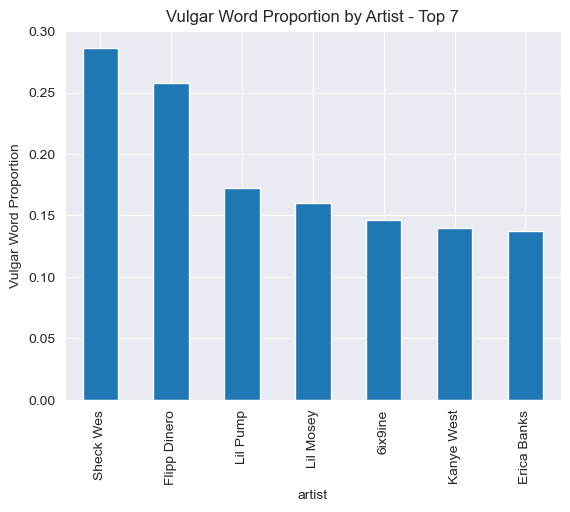

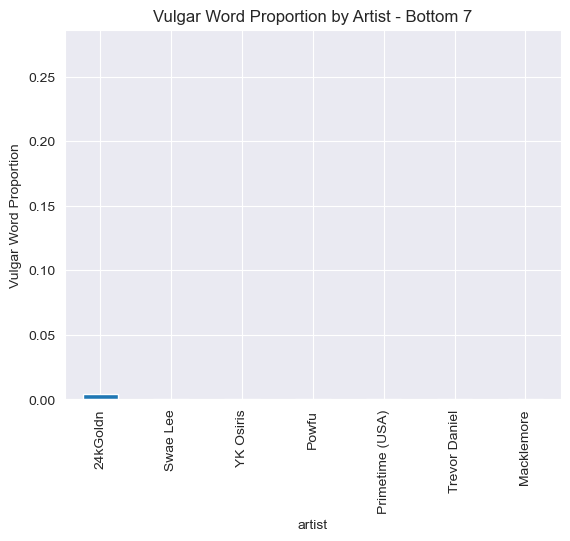

In [32]:
# proportion of swear words per artist over all years
artist_swears = swear_by_year_artist.groupby("artist")["swear_proportion"].mean().sort_values(ascending=False)
# plot top 7
artist_swears.head(7).plot(kind="bar")
plt.ylabel("Vulgar Word Proportion")
plt.title("Vulgar Word Proportion by Artist - Top 7")
plt.show()

# bottom 7
artist_swears.tail(7).plot(kind="bar")
plt.ylabel("Vulgar Word Proportion")
plt.title("Vulgar Word Proportion by Artist - Bottom 7")
plt.ylim([0,artist_swears.values[0]])
plt.show()

In [33]:
n = 15
# top n artists with the highest swear word proportions
top_artists = list(artist_swears.head(n).index)
# top n artists with the lowest swear word proportions
bottom_artists = list(artist_swears.tail(n).index)

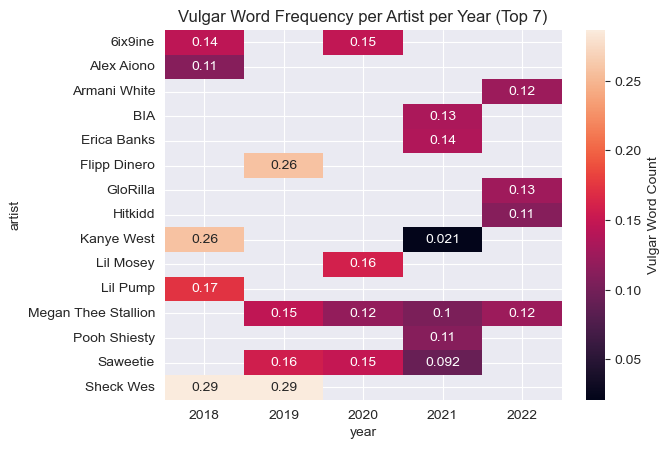

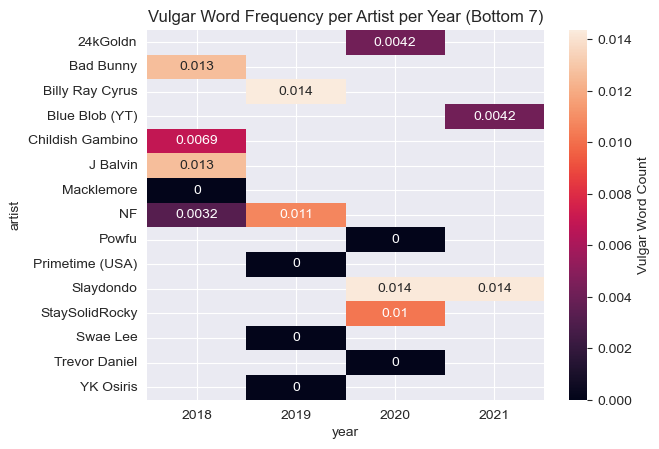

In [34]:
# heatmap of top n toxic artists
swear_by_year_artist_filtered = swear_by_year_artist[swear_by_year_artist["artist"].isin(top_artists)]
swear_by_year_artist_pivot_heatmap = swear_by_year_artist_filtered.pivot_table(index="artist", columns="year", values="swear_proportion", fill_value=None)
sns.heatmap(swear_by_year_artist_pivot_heatmap, annot=True,  cbar_kws={"label": "Vulgar Word Count"})
plt.title("Vulgar Word Frequency per Artist per Year (Top 7)")
plt.show()

# heatmap of least n toxic artists
swear_by_year_artist_filtered = swear_by_year_artist[swear_by_year_artist["artist"].isin(bottom_artists)]
swear_by_year_artist_pivot_heatmap = swear_by_year_artist_filtered.pivot_table(index="artist", columns="year", values="swear_proportion", fill_value=None)
sns.heatmap(swear_by_year_artist_pivot_heatmap, annot=True,  cbar_kws={"label": "Vulgar Word Count"})
plt.title("Vulgar Word Frequency per Artist per Year (Bottom 7)")
plt.show()

## Vulgarity in Songs & Correlation between song ranking and swear word proportion

In [35]:
# create a dictionary keyed by the song title which contains the swear word proportion
song_swear_proportion_dict = {}

for index, row in songs_data.iterrows():
    words = row["Lyrics"]
    title = row["title"]
    word_counts = dict(Counter(words))
    df = word_count_dict_to_df(word_counts)
    df["swear word"] = df.index.isin(bad_words_data["jigaboo"])
    # swear word proportion
    total_words =  df["count"].sum()
    swear_words =  df[df["swear word"]]["count"].sum()
    song_swear_proportion_dict[title] = swear_words/total_words

swear_proportion_data = []

for title, proportion in song_swear_proportion_dict.items():
    ranking = songs_data.loc[songs_data["title"] == title, "position"].values[0]
    swear_proportion_data.append({"title": title, "ranking": ranking, "swear_proportion": proportion})

swear_proportion_df = pd.DataFrame(swear_proportion_data)
swear_proportion_df = swear_proportion_df.sort_values("swear_proportion", ascending=False)

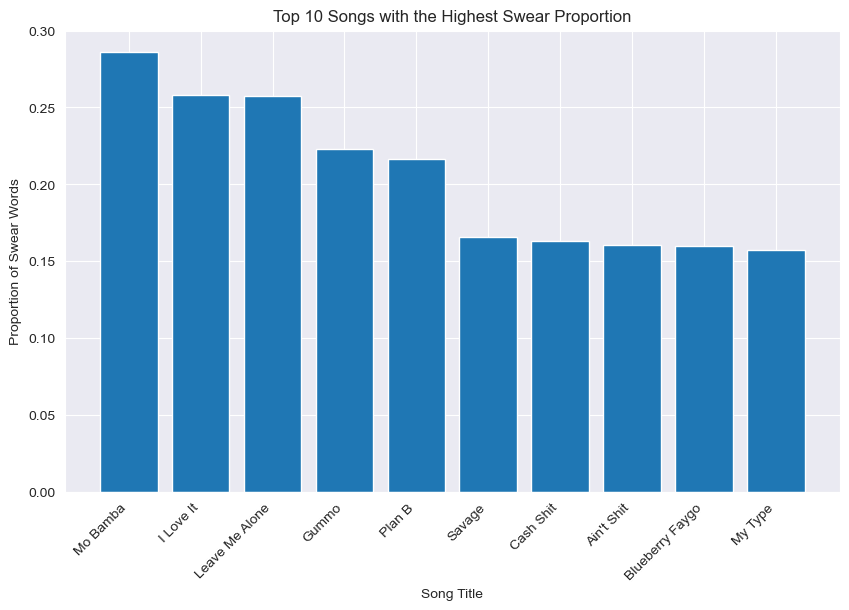

In [36]:
# Create a bar plot of the top n songs
n = 10
plt.figure(figsize=(10, 6))
plt.bar(swear_proportion_df.head(n)["title"], swear_proportion_df.head(n)["swear_proportion"])
plt.xlabel("Song Title")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion of Swear Words")
plt.title("Top " + str(n) + " Songs with the Highest Swear Proportion")
plt.show()

We can see that some songs consist of up to 30% swear words! "I Love It" was the song with the highest proportion of vulgarity.

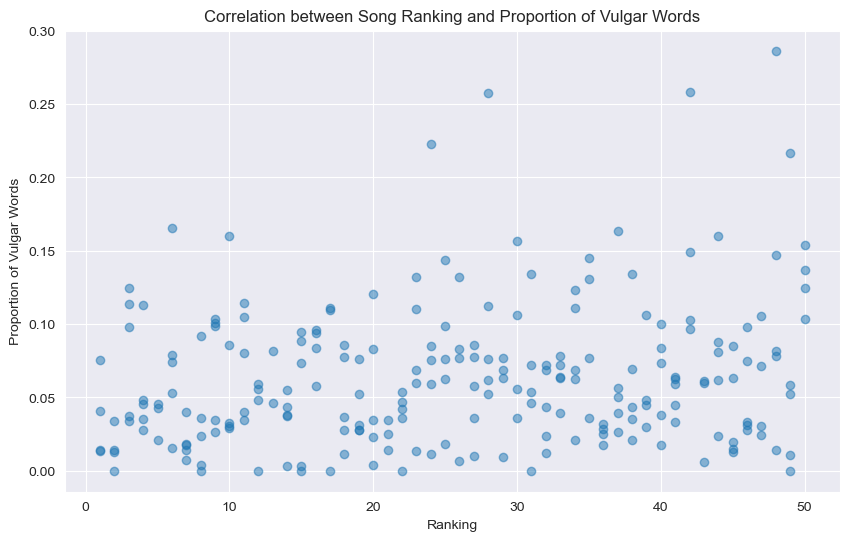

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(swear_proportion_df["ranking"], swear_proportion_df["swear_proportion"], alpha=0.5)
plt.xlabel("Ranking")
plt.ylabel("Proportion of Vulgar Words")
plt.title("Correlation between Song Ranking and Proportion of Vulgar Words")
plt.show()

As the scatter plot shows, there seems to be no clear correlation between the song ranking and the swear words, and therefore we can not attribute a song's popularity to vulgarity.


Overall, it is frightening how prominent vulgarity is in rap. Moreover, as we could see, certain rappers are more likely to use swear words than others. However, there is no clear correlation between the song ranking and the use of swear words, which may imply that listeners do not prefer listening to more vulgar lyrics.

# Ethical Considerations
The source of the lyrics data is the Genius website, acquired via the Genius API. Genius is a well-known site for lyrics aggregation and is highly likely to be correct. A number of considerations were made for this analysis. Firstly, the lyrics data was compared to a set of stop words and swear words to filter these out and highlight them respectively. These sets of words are of course not definitive, as the definition of a swear word might be different in the perspective of others. An important decision that we considered was whether to filter stop words or not. For some parts of the analysis, this proved to be beneficial, whereas for other parts we did not do this to give a more fair view of the data, such as in measuring the average word length. Another decision we had to make was applying lemmatization of the dataset, i.e. grouping together different forms of the same word. Again, this was beneficial only for some parts of the analysis. A major limitation to this analysis is that the data used was limited to 250 songs made by many different artists. This only gives a small sample of songs by each artist, and limits the confidence we can place in our conclusions. The people affected by the analysis in some way are the artists of the songs in the data, as well as the listeners of these artists. Because the analysis draws conclusions about the vocabulary and vulgarity of the artists, they might be either positively affected if the attributed traits are seen as positive, as well as harmed if the attributed traits are seen as negative by themselves and their listeners especially. Finally, this data perhaps does not give an accurate representation of all active rap artists as the sample used is limited in scope.
